In [1]:
import pandas as pd
import numpy as np

import sys
import os

from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [3]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, AveragePooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import metrics

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
features_df = pd.read_csv('./features/features-no-uk-v1.csv')
features_uk_df = pd.read_csv('./features/features-uk-only-v1.csv')

features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.174738,0.648226,0.677165,0.692260,0.716191,0.665501,0.607874,0.632416,0.642000,0.712695,...,0.008625,0.008645,0.009090,0.010604,0.011772,0.008924,0.003265,0.001107,0.000084,fear
1,0.252287,0.713152,0.745960,0.769096,0.762554,0.728579,0.661987,0.659903,0.686460,0.755400,...,0.011694,0.011428,0.012471,0.013722,0.014640,0.011388,0.005821,0.003910,0.003054,fear
2,0.174738,0.648226,0.677165,0.692260,0.716191,0.665501,0.607874,0.632416,0.642000,0.712695,...,0.008625,0.008645,0.009090,0.010604,0.011772,0.008924,0.003265,0.001107,0.000084,fear
3,0.181625,0.643610,0.581965,0.477430,0.558267,0.605189,0.522657,0.561186,0.614690,0.624254,...,0.183382,0.144932,0.060404,0.048087,0.056380,0.072826,0.076891,0.034622,0.004218,fear
4,0.238893,0.683777,0.635173,0.549861,0.612256,0.639177,0.560762,0.587642,0.635393,0.645892,...,0.184496,0.148167,0.064108,0.050857,0.059945,0.077811,0.082175,0.038339,0.007538,fear


In [5]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39831 entries, 0 to 39830
Columns: 163 entries, 0 to labels
dtypes: float64(162), object(1)
memory usage: 49.5+ MB


In [6]:
emotions_number = 8

In [7]:
X = features_df.iloc[:, :-1].values
y = features_df['labels'].values

In [8]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

In [9]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=True)

print(
    f'train:\t {x_train.shape, y_train.shape,}\ntest:\t{x_test.shape, y_test.shape}')

train:	 ((31864, 162), (31864, 8))
test:	((7967, 162), (7967, 8))


In [10]:
# Split once to get the test and validation set
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size=0.3, random_state=42)
print(
    f'val:\t {x_val.shape, y_val.shape,}\ntest:\t{x_test.shape, y_test.shape}')

val:	 ((5576, 162), (5576, 8))
test:	((2391, 162), (2391, 8))


In [11]:
# # scaling our data with sklearn's Standard scaler
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)
# x_val = scaler.fit_transform(x_val)
# print(
#     f'train:\t {x_train.shape, y_train.shape,}\ntest:\t{x_val.shape, y_val.shape}\ntest: {x_test.shape, y_test.shape}')

## Model, train


In [12]:
model = Sequential()
model.add(Conv1D(64, kernel_size=7, padding='same',
          activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
model.add(AveragePooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
model.add(AveragePooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=emotions_number, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 64)           512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 64)            12352     
                                                                 
 conv1d_2 (Conv1D)           (None, 81, 64)            12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 81, 64)            12352     
                                                                 
 conv1d_4 (Conv1D)           (None, 81, 64)            12352     
                                                        

In [13]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4,
                         verbose=0, patience=2, min_lr=0.0000001)


history = model.fit(x_train, y_train, batch_size=32, epochs=100,
                    validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
996/996 [==============================] - 23s 19ms/step - loss: 1.6506 - accuracy: 0.3305 - val_loss: 1.5489 - val_accuracy: 0.3664 - lr: 0.0010
Epoch 2/100
996/996 [==============================] - 17s 17ms/step - loss: 1.4679 - accuracy: 0.4051 - val_loss: 1.4280 - val_accuracy: 0.4337 - lr: 0.0010
Epoch 3/100
996/996 [==============================] - 17s 17ms/step - loss: 1.3726 - accuracy: 0.4526 - val_loss: 1.3222 - val_accuracy: 0.4659 - lr: 0.0010
Epoch 4/100
996/996 [==============================] - 17s 17ms/step - loss: 1.2977 - accuracy: 0.4820 - val_loss: 1.2663 - val_accuracy: 0.4764 - lr: 0.0010
Epoch 5/100
996/996 [==============================] - 17s 17ms/step - loss: 1.2507 - accuracy: 0.4987 - val_loss: 1.2348 - val_accuracy: 0.4902 - lr: 0.0010
Epoch 6/100
996/996 [==============================] - 17s 17ms/step - loss: 1.2190 - accuracy: 0.5104 - val_loss: 1.2399 - val_accuracy: 0.5077 - lr: 0.0010
Epoch 7/100
996/996 [==============================]

In [14]:
def print_report(model, history, test_x, test_y):
    print("Accuracy of our model on test data : ",
          model.evaluate(test_x, test_y)[1]*100, "%")

    epochs = history.epoch

    fig, ax = plt.subplots(1, 2)

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20, 6)
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")

    plt.show()

In [15]:
def print_confusion_matrix(test, pred, size=(12, 10)):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=size)
    cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
        i for i in encoder.categories_])
    sns.heatmap(cm, linecolor='white', cmap='Blues',
                linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

 1/75 [..............................] - ETA: 6s - loss: 0.1138 - accuracy: 0.9688

75/75 [==============================] - 1s 12ms/step - loss: 0.3801 - accuracy: 0.9055
Accuracy of our model on test data :  90.54788947105408 %


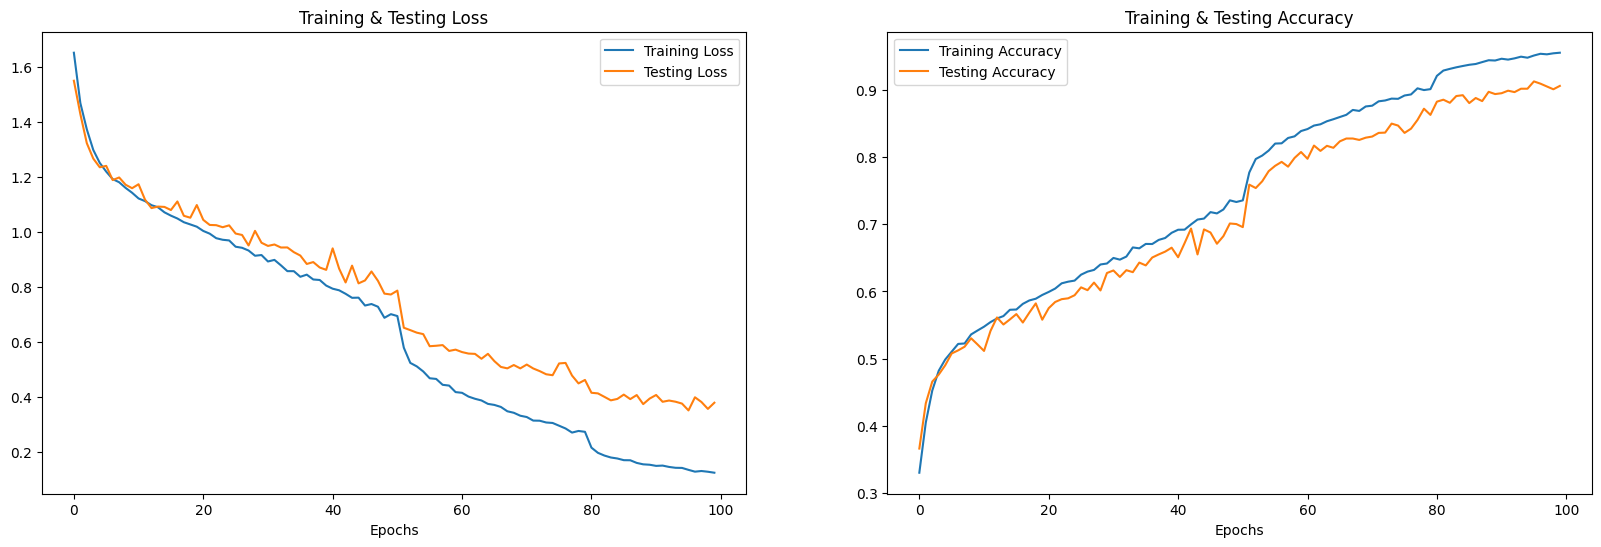

In [16]:
print_report(model, history, x_test, y_test)

In [17]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test_decoded = encoder.inverse_transform(y_test)

75/75 [==============================] - 1s 8ms/step


In [18]:
# df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
# df['Predicted Labels'] = y_pred.flatten()
# df['Actual Labels'] = y_test_decoded.flatten()

# df.head(10)

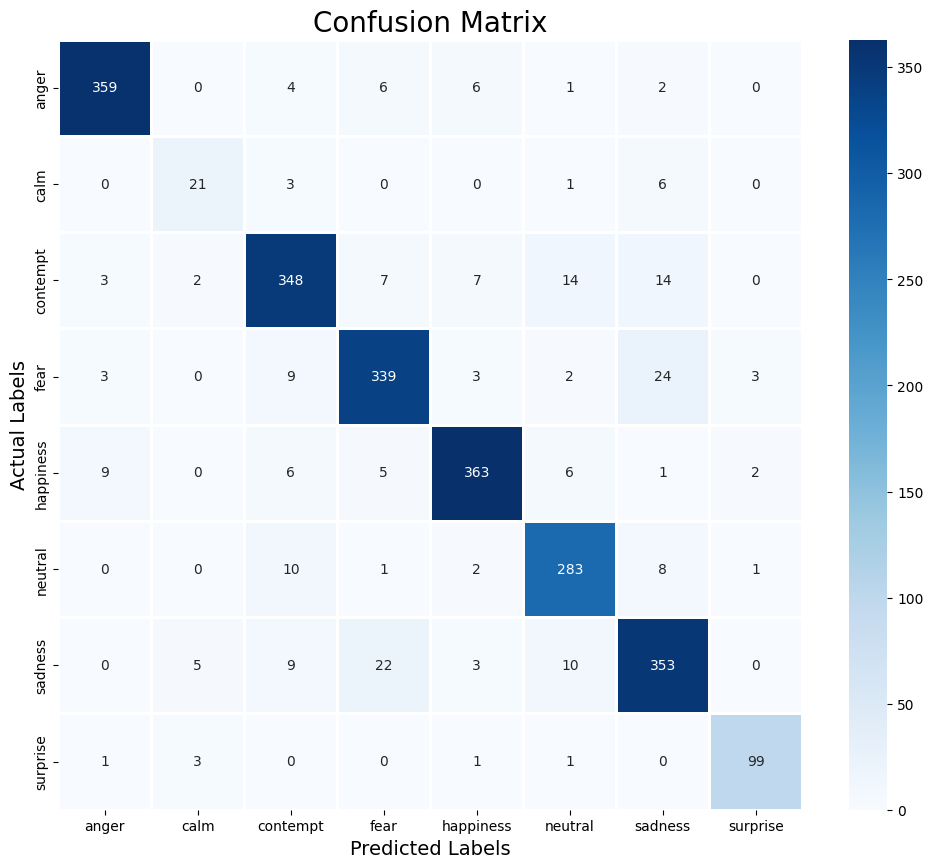

In [19]:
print_confusion_matrix(y_test_decoded, y_pred)

In [20]:
print(classification_report(y_test_decoded, y_pred))

              precision    recall  f1-score   support

       anger       0.96      0.95      0.95       378
        calm       0.68      0.68      0.68        31
    contempt       0.89      0.88      0.89       395
        fear       0.89      0.89      0.89       383
   happiness       0.94      0.93      0.93       392
     neutral       0.89      0.93      0.91       305
     sadness       0.87      0.88      0.87       402
    surprise       0.94      0.94      0.94       105

    accuracy                           0.91      2391
   macro avg       0.88      0.88      0.88      2391
weighted avg       0.91      0.91      0.91      2391



## Save model


In [21]:
model.save('./saved_models/ser-main-v4-no-uk.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('./saved_models/ser-main-v4-no-uk.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmpaqopaohn\assets


INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmpaqopaohn\assets


metadata (skip for now)


In [22]:
# from tflite_support import flatbuffers
# from tflite_support import metadata as _metadata
# from tflite_support import metadata_schema_py_generated as _metadata_fb

# # Creates model info.
# model_meta = _metadata_fb.ModelMetadataT()
# model_meta.name = "Speech emotion recognition"
# model_meta.description = ("Identify emotion of human voice")
# model_meta.version = "v2"
# model_meta.author = "Mykola Nosenko"
# model_meta.license = ("Apache License. Version 2.0 "
#                       "http://www.apache.org/licenses/LICENSE-2.0.")  # verify later

In [23]:
# # Creates output info.
# output_meta = _metadata_fb.TensorMetadataT()
# output_meta.name = "probability"
# output_meta.description = "Probabilities of the 8 labels respectively."
# output_meta.content = _metadata_fb.ContentT()
# output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
# output_meta.content.contentPropertiesType = (
#     _metadata_fb.ContentProperties.FeatureProperties)
# output_stats = _metadata_fb.StatsT()
# output_stats.max = [1.0]
# output_stats.min = [0.0]
# output_meta.stats = output_stats
# label_file = _metadata_fb.AssociatedFileT()
# label_file.name = os.path.basename("./emotion_labels.txt")
# label_file.description = "Labels for emotions that the model can recognize."
# label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
# output_meta.associatedFiles = [label_file]

In [24]:
# # Creates subgraph info.
# subgraph = _metadata_fb.SubGraphMetadataT()
# # subgraph.inputTensorMetadata = [input_meta]
# subgraph.outputTensorMetadata = [output_meta]
# model_meta.subgraphMetadata = [subgraph]

# b = flatbuffers.Builder(0)
# b.Finish(
#     model_meta.Pack(b),
#     _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
# metadata_buf = b.Output()

In [25]:
# populator = _metadata.MetadataPopulator.with_model_file('./model.tflite')
# populator.load_metadata_buffer(metadata_buf)
# populator.load_associated_files(["./emotion_labels.txt"])
# populator.populate()

In [26]:
# displayer = _metadata.MetadataDisplayer.with_model_file(
#     "./model.tflite")
# export_json_file = os.path.join("D:/Documents/export_models/model.json")
# json_file = displayer.get_metadata_json()
# # Optional: write out the metadata as a json file
# with open(export_json_file, "w") as f:
#     f.write(json_file)

In [27]:
# # Convert the model
# converter = tf.lite.TFLiteConverter.from_saved_model(
#     "./saved_models/ser4.keras")  # path to the SavedModel directory
# tflite_model = converter.convert()

# # Save the model.
# with open('ser4-model.tflite', 'wb') as f:
#     f.write(tflite_model)

## Test model


In [28]:
# model_l = tf.keras.models.load_model('./saved_models/ser4-v4.keras')
# model_l.summary()

In [29]:
X_uk = features_uk_df.iloc[:, :-1].values
y_uk = features_uk_df['labels'].values

In [30]:
fear_label = 'fear'
contempt_label = 'contempt'  # disgust
happiness_label = 'happiness'
anger_label = 'anger'
sadness_label = 'sadness'
neutral_label = 'neutral'
surprise_label = 'surprise'
calm_label = 'calm'

emotions = [fear_label, contempt_label, happiness_label, anger_label,
            sadness_label, neutral_label, surprise_label, calm_label]

In [31]:
encoder_uk = OneHotEncoder(categories=[emotions])
y_uk = encoder_uk.fit_transform(np.array(y_uk).reshape(-1, 1)).toarray()

In [32]:
loss, acc = model.evaluate(X_uk, y_uk, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

3/3 - 1s - loss: 27.2965 - accuracy: 0.0769 - 845ms/epoch - 282ms/step
Restored model, accuracy:  7.69%


In [33]:
pred_uk = model.predict(X_uk)
pred_uk_decoded = encoder_uk.inverse_transform(pred_uk)
y_uk_decoded = encoder_uk.inverse_transform(y_uk)
print(pred_uk_decoded.shape)
print(y_uk_decoded.shape)

3/3 [==============================] - 0s 7ms/step
(78, 1)
(78, 1)


In [34]:
cm = confusion_matrix(y_uk_decoded, pred_uk_decoded)
cm

array([[ 0,  0,  0,  6,  0,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  0],
       [10,  0,  0,  3, 11,  2, 10],
       [ 0,  0,  0,  0,  0,  3,  3],
       [ 0,  3,  2,  2,  6,  2,  9],
       [ 0,  0,  0,  0,  0,  0,  3],
       [ 0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [35]:
print(classification_report(y_uk_decoded, pred_uk_decoded))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         9
        calm       0.00      0.00      0.00         0
    contempt       0.00      0.00      0.00        36
        fear       0.00      0.00      0.00         6
   happiness       0.35      0.25      0.29        24
     sadness       0.00      0.00      0.00         3
    surprise       0.00      0.00      0.00         0

    accuracy                           0.08        78
   macro avg       0.05      0.04      0.04        78
weighted avg       0.11      0.08      0.09        78



In [38]:
from model_analyzer import get_model_memory_usage


print(f'Memory usage: {get_model_memory_usage(32, model)} GB')

Memory usage: 0.021 GB
